In [20]:
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
import tensorflow as tf
import cv2
import os
import zipfile
import urllib.request
import random
from sklearn.model_selection import train_test_split
import urllib.request
import tarfile
import matplotlib.pyplot as plt
from PIL import Image
import math

In [21]:
def dcp(img, size):
    min_per_pixel = np.min(img, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark = cv2.erode(min_per_pixel, kernel)
    return dark

In [22]:
import tensorflow as tf

def vchannel(img):
    hsv = tf.image.rgb_to_hsv(img)
    v = hsv[:,:, 2]
    return v


In [23]:
def extract_multiscale_dark_channels(img):
    patch_size=[1, 3, 5, 7, 10]
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    v = vchannel(img_tensor)
    v = v.numpy()
    dark_channels = []
    for s  in patch_size:
      temp = dcp(img,s)
      dark_channels.append(temp)
    temp1 = np.stack([v] + dark_channels, axis=0)  # (6, H, W)
    tensor = np.transpose(temp1, (1, 2, 0))        # (H, W, C)
    #tensor = np.expand_dims(tensor, axis=0)
    return tensor.astype(np.float32)

In [24]:


model = Sequential([
    tf.keras.layers.Input(shape=(None, None, 6)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.05)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.05)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.05)),
    tf.keras.layers.Conv2D(8,  3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.05)),
    tf.keras.layers.Conv2D(1,  3, padding='same', activation='sigmoid')
])



In [25]:
def image_recover(I,t, A=(0.95, 0.95, 0.95), t_min=0.1):
    #t = np.exp(-beta * depth)
    t = np.clip(t, t_min, 1.0)[:, :, np.newaxis]
    A = np.array(A)
    J = (I - A) / t + A
    return np.clip(J, 0, 1)


In [26]:
import numpy as np

def image_recover1(I, depth, beta, A=(0.95, 0.95, 0.95), t_min=0.1):
    # Ensure float image in [0,1]
    if I.dtype != np.float32 and I.max() > 1:
        I = I.astype(np.float32) / 255.0

    # Compute transmission map
    t = np.exp(-beta * depth)
    t = np.clip(t, t_min, 1.0)[:, :, np.newaxis]  # shape (H, W, 1)

    A = np.array(A).reshape((1, 1, 3))  # ensure broadcast shape

    # Recover the image
    J = (I - A) / t + A
    return np.clip(J, 0, 1)


In [27]:
def hazyimagemaker(patch, t, A):
    return patch * t + A * (1 - t)

def extract_patches_pair(img, trans, patch_size, num_patches):
    H, W = img.shape[:2]
    patches_img = []
    patches_trans = []

    for _ in range(num_patches):
        y = random.randint(0, H - patch_size)
        x = random.randint(0, W - patch_size)

        patch_img = img[y:y + patch_size, x:x + patch_size]
        patch_trans = trans[y:y + patch_size, x:x + patch_size]

        patches_img.append(patch_img)
        patches_trans.append(patch_trans)

    return patches_img, patches_trans


In [28]:
import h5py

def load_transmission_map(mat_path):
    with h5py.File(mat_path, 'r') as f:
        # adjust 'depth' if key is different
        data = f['depth'][:]
        # transpose if needed
        data = data.T
        return data


In [29]:
import h5py
import numpy as np
import cv2

def prepare_dataset(image_paths, batchsize, patchesnumber, patchsize, epochs):
    processed_images_X, y = [], []
    path_not_read = []

    for hazy_path in image_paths:
        trans_path = get_trans_path(hazy_path)

        # Load hazy RGB image
        img = cv2.imread(hazy_path)
        if img is None:
            print(f"[WARN] Could not read hazy image: {hazy_path}")
            path_not_read.append(hazy_path)
            continue

        # Load transmission map (.mat file)
        try:
            with h5py.File(trans_path, 'r') as f:
                keys = list(f.keys())
                if not keys:
                    raise ValueError(f"No datasets found in {trans_path}")
                key = keys[0]  # typically 'depth' or similar
                trans = f[key][:]
                trans = np.array(trans).T  # MATLAB column-major -> row-major
        except Exception as e:
            print(f"[WARN] Failed to read transmission map: {trans_path}, error: {e}")
            path_not_read.append(hazy_path)
            continue

        # Normalize
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        trans = trans.astype(np.float32)
        trans = np.clip(trans, 0, np.percentile(trans, 99))  # remove extreme outliers
        trans = trans / np.percentile(trans, 99)  #

        # Extract paired patches
        img_patches, trans_patches = extract_patches_pair(img, trans, patchsize, patchesnumber)

        for img_patch, trans_patch in zip(img_patches, trans_patches):
            # Compute dark channel features (6-channel tensor)
            six_channel_tensor = extract_multiscale_dark_channels(img_patch)

            processed_images_X.append(six_channel_tensor.astype(np.float32))
            y.append(np.expand_dims(trans_patch, axis=-1).astype(np.float32))

    print(f"\n✅ Finished preparing dataset.")
    print(f"   Total samples: {len(processed_images_X)}")
    print(f"   Unreadable hazy/transmission pairs: {len(path_not_read)}")

    return np.array(processed_images_X, dtype=np.float32), np.array(y, dtype=np.float32)


In [30]:
import os
import random

def get_image_paths(folder, num=250):
    image_paths = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, f))

    print(f"Found {len(image_paths)} images in dataset")

    if len(image_paths) < num:
        raise ValueError(f"Found only {len(image_paths)} images, need at least {num}")

    # Random sample
    return random.sample(image_paths, num)


In [31]:
import os

def get_trans_path(hazy_path):
    filename = os.path.basename(hazy_path)
    image_id = filename.split('_')[0]   # e.g., '0025'
    trans_filename = f"{image_id}.mat"

    # adjust this base directory to wherever your .mat files actually are:
    trans_base_dir = '/kaggle/input/transdata/depth/depth/depth'
    trans_path = os.path.join(trans_base_dir, trans_filename)

    return trans_path


In [32]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

def train_dcnet_model(model, image_paths, batchsize, patchesnumber, patchsize, epochs):
    X, y = prepare_dataset(image_paths, batchsize, patchesnumber, patchsize, epochs)

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
    )

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='mse'
    )

    history = model.fit(
        X_train, y_train,
        batch_size=batchsize,
        epochs=epochs,
        shuffle=True,
        validation_data=(X_val, y_val)
    )

    y_pred_all = model.predict(X_test)
    y_pred_all = np.squeeze(y_pred_all, axis=-1)
    test_loss = model.evaluate(X_test, y_test)

    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("DCNet Training Loss")
    plt.legend()
    plt.show()

    return X_test, y_pred_all, y_test, test_loss


Found 72135 images in dataset
✅ Selected 500 random hazy images for training.

✅ Finished preparing dataset.
   Total samples: 25000
   Unreadable hazy/transmission pairs: 0
Epoch 1/20


I0000 00:00:1755508288.911233      99 service.cc:148] XLA service 0x7cf27c003a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755508288.911882      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755508288.911904      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755508289.093119      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 59/625 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0347

I0000 00:00:1755508291.139530      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0274 - val_loss: 0.0259
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0249 - val_loss: 0.0261
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0246 - val_loss: 0.0254
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0241 - val_loss: 0.0253
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0245 - val_loss: 0.0252
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0242 - val_loss: 0.0251
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0242 - val_loss: 0.0251
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0239 - val_loss: 0.0252
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0241 - val_loss: 0.0248
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0242 - val_loss: 0.0250
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0240 - val_loss: 0.0249
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

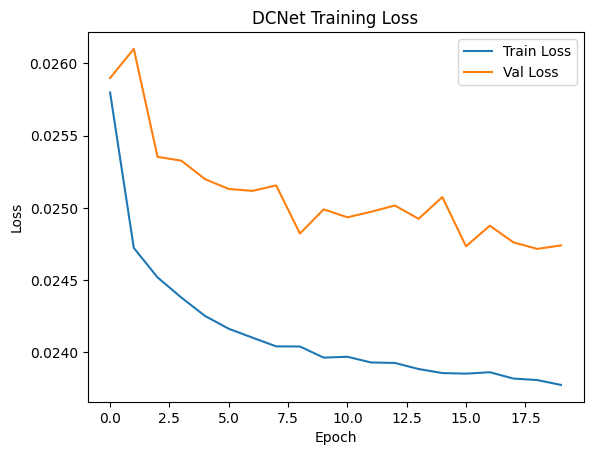


✅ Training complete! Test loss: 0.0241
Shapes: X_test=(2500, 20, 20, 6), y_pred_all=(2500, 20, 20), y_test=(2500, 20, 20, 1)


In [33]:
patchsize = 20
patchesnumber = 50
batchsize = 32
epochs = 20

# Step 1: get random hazy images
image_paths = get_image_paths(
    "/kaggle/input/outdoor-training-set-ots-reside/hazy", 
    num= 500
)
print(f"✅ Selected {len(image_paths)} random hazy images for training.")

# Step 2: train model
X_test, y_pred_all, y_test, test_loss = train_dcnet_model(
    model, 
    image_paths, 
    batchsize=batchsize, 
    patchesnumber=patchesnumber, 
    patchsize=patchsize, 
    epochs=epochs
)

print(f"\n✅ Training complete! Test loss: {test_loss:.4f}")
print(f"Shapes: X_test={X_test.shape}, y_pred_all={y_pred_all.shape}, y_test={y_test.shape}")


In [34]:
from sklearn.metrics import mean_squared_error
y_test_flat = np.ravel(y_test)
y_pred_flat = np.ravel(y_pred_all)
ans = mean_squared_error(y_test_flat, y_pred_flat)
ans

0.024060493

In [35]:
len(X_test)

2500

**SSIR*

In [36]:
y_pred_test =[]
image_dehazed_test=[]
hazy_patch_test=[]

for i in range(0, len(X_test)):
    hazy_patch = X_test[i][:, :, :3]
    pred_t = y_pred_all[i]
    gt_t = y_test[i, :, :, 0]
    dehazed = image_recover(hazy_patch, pred_t)
    image_dehazed_test.append(dehazed)
    hazy_patch_test.append(hazy_patch)



In [37]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [38]:
ssim_value_test =[]
for i in range(0, len(X_test)):
  img_fixed = hazy_patch_test[i].astype(np.float32) / 255.0
  dehazed_result = image_dehazed_test[i].astype(np.float32) / 255.0
  height, width = img_fixed.shape[:2]
  min_dim = min(height, width)
  win_size = min_dim if min_dim % 2 == 1 else min_dim - 1
  ssim_value = ssim(
    img_fixed,
    dehazed_result,
    win_size=win_size,
    channel_axis=-1,
    data_range=1.0
  )
  ssim_value_test.append(ssim_value)

In [39]:
mean_ssim = sum(ssim_value_test)/len(ssim_value_test)
mean_ssim

0.9949839553117752

**PSNR**

In [40]:
import math

In [41]:
avg_img_test =[]
PSNR_img_test=[]
for i in range(0, len(X_test)):
  g_img = cv2.cvtColor(hazy_patch_test[i], cv2.COLOR_BGR2GRAY)
  avg_intensity = np.mean(g_img)
  avg_img_test.append(avg_intensity)
  MSE_temp = mean_squared_error(y_test_flat[i],y_pred_flat[i])
  PSNR = 20 * math.log10(avg_intensity / (MSE_temp)**0.5)
  PSNR_img_test.append(PSNR)

In [42]:
mean_PSNR = sum(PSNR_img_test)/len(PSNR_img_test)
mean_PSNR

21.215536756651872

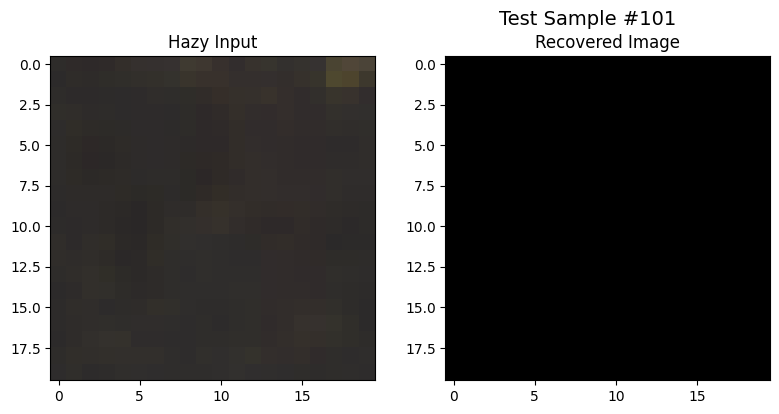

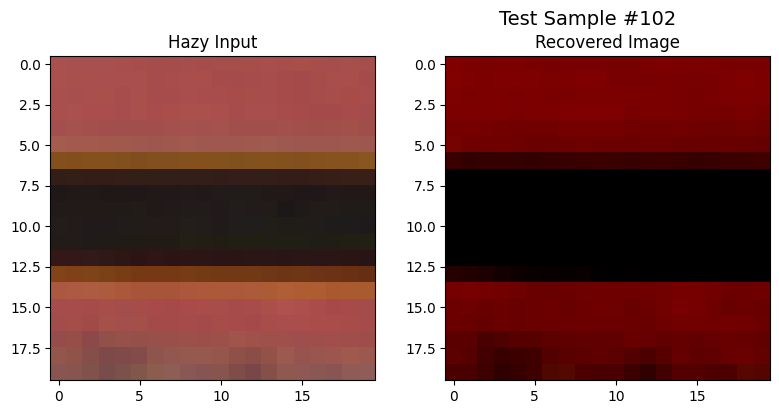

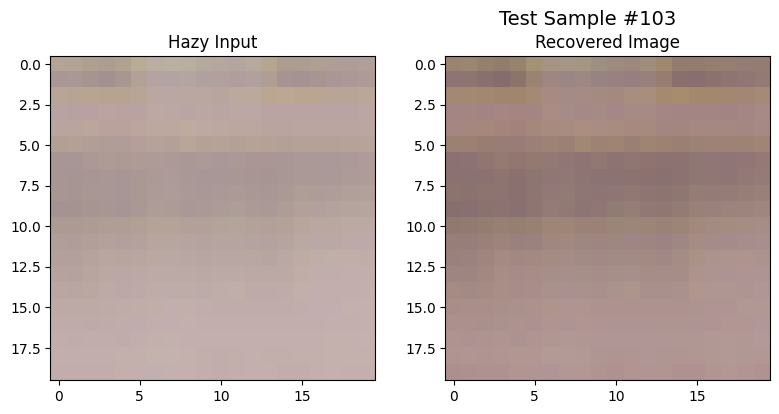

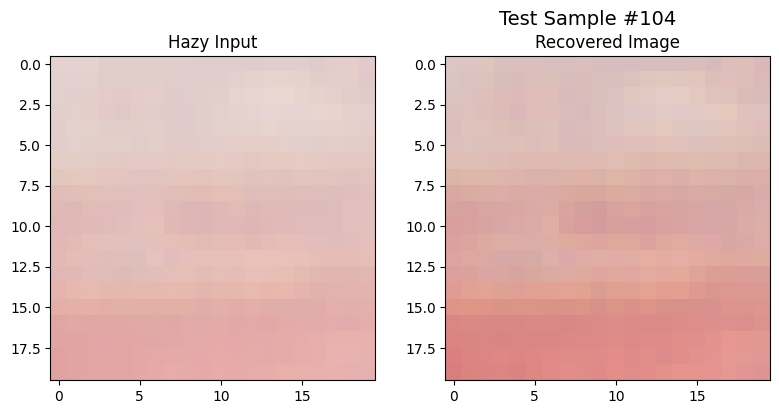

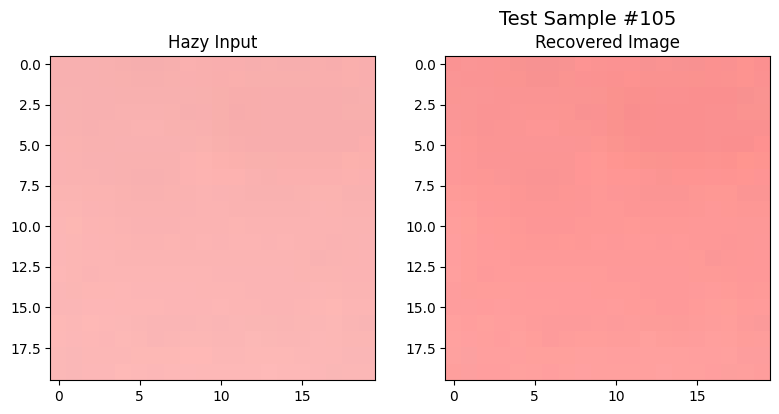

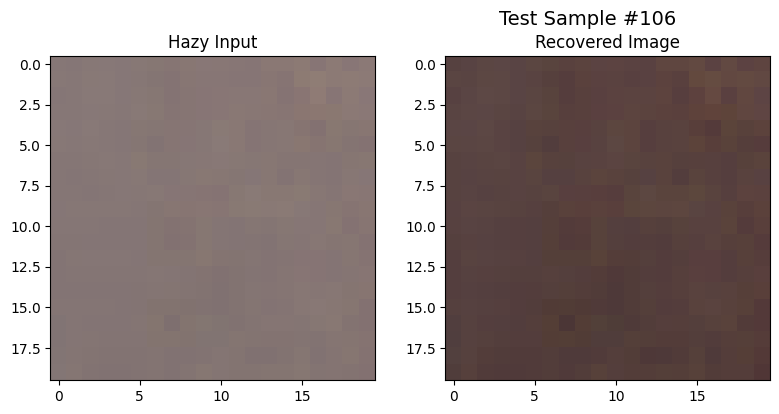

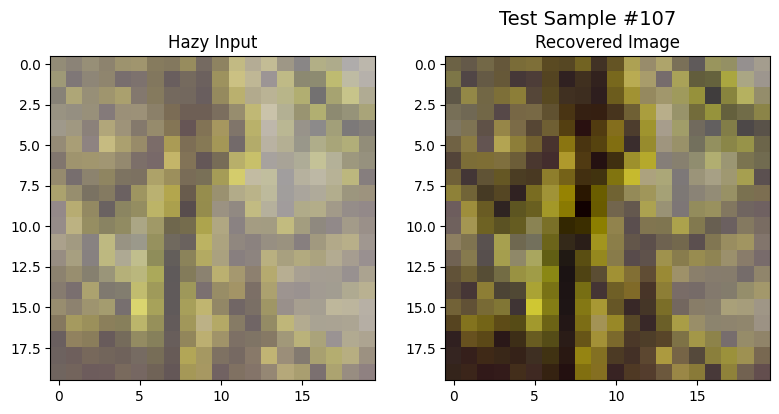

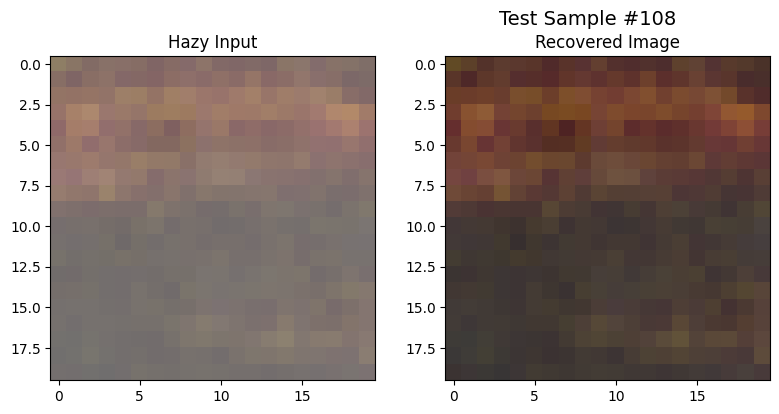

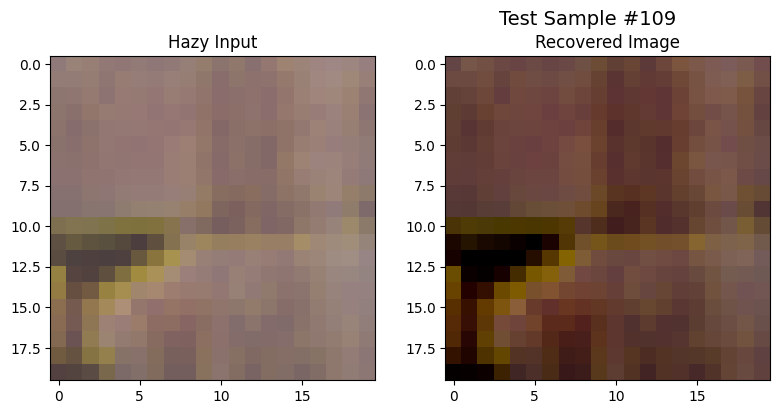

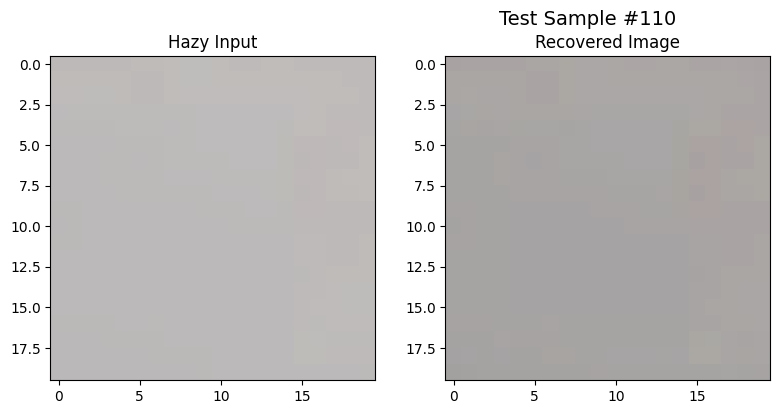

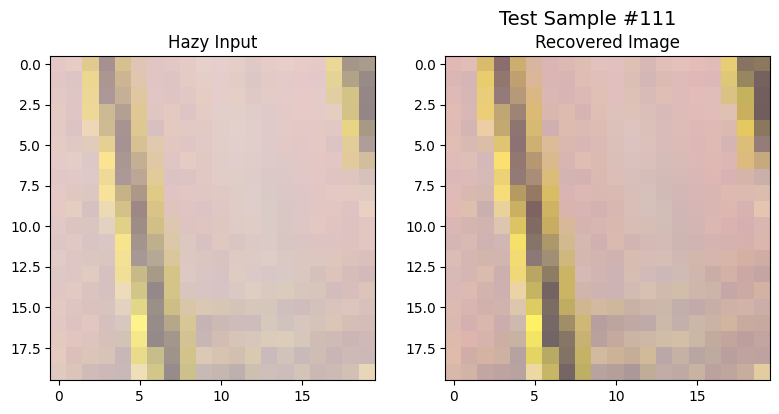

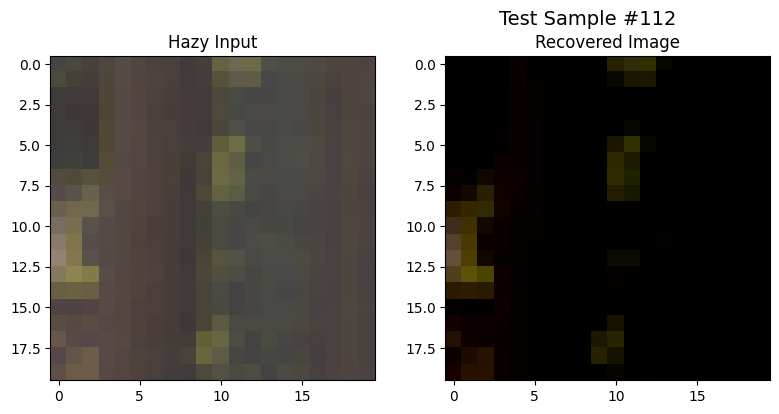

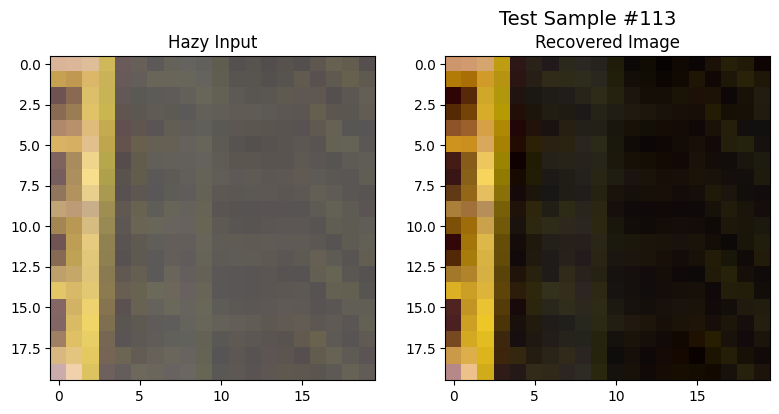

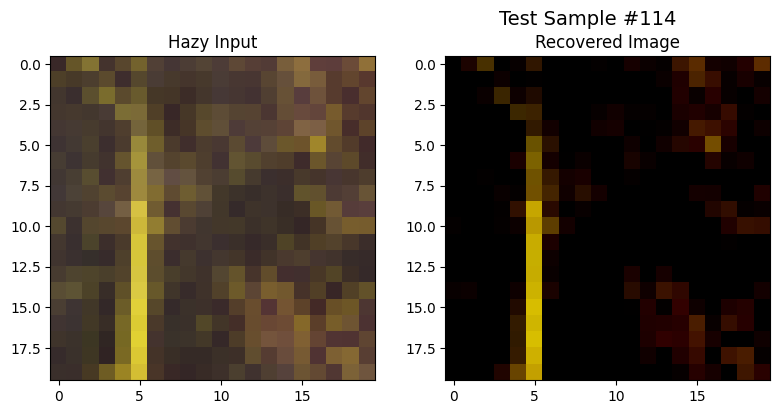

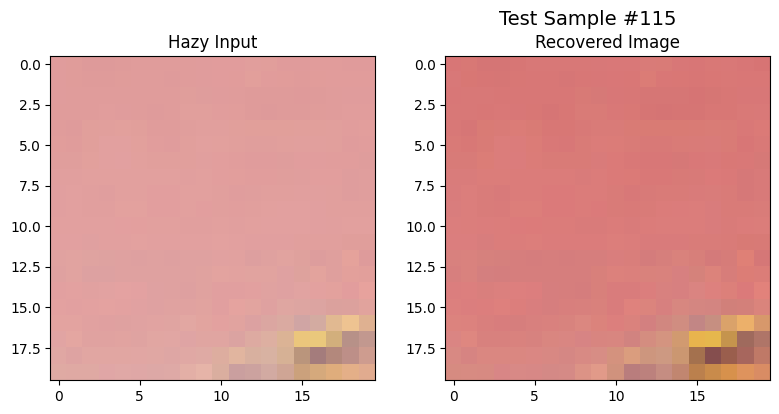

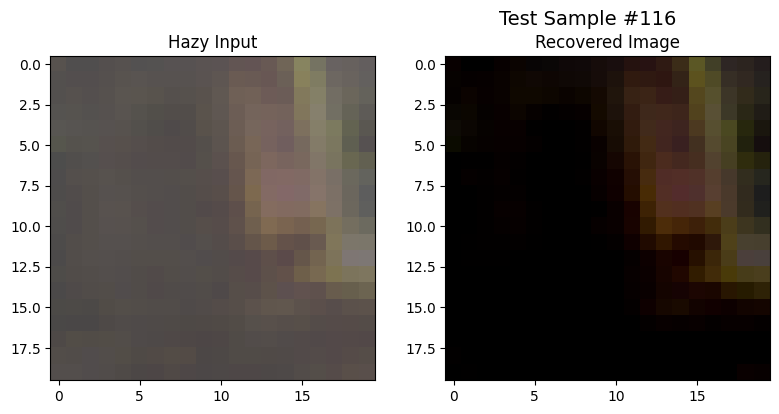

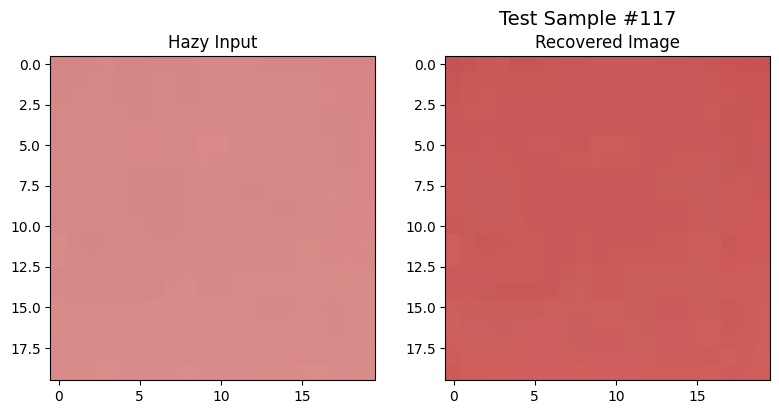

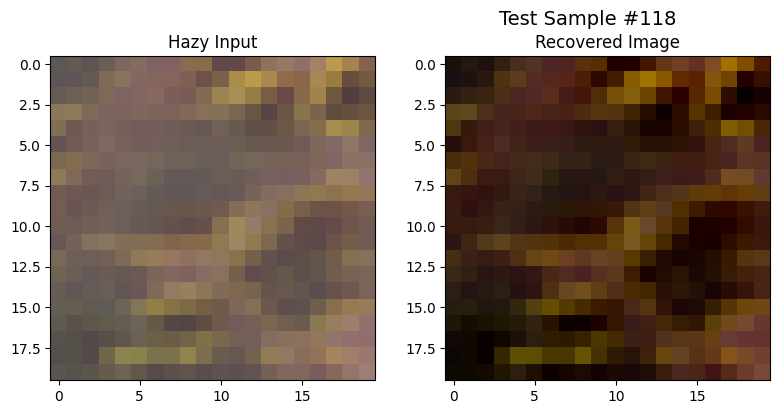

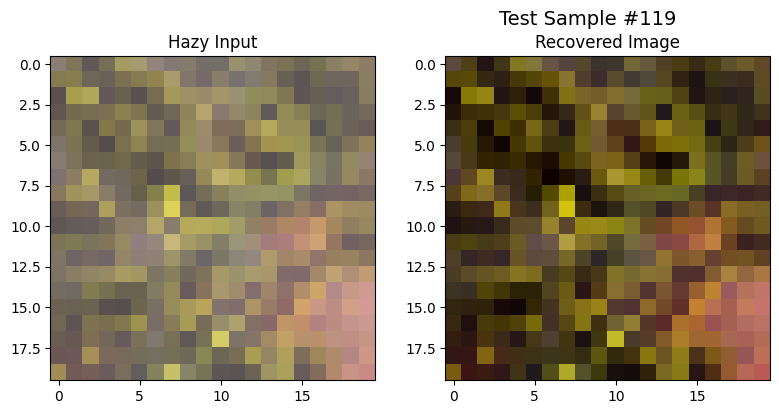

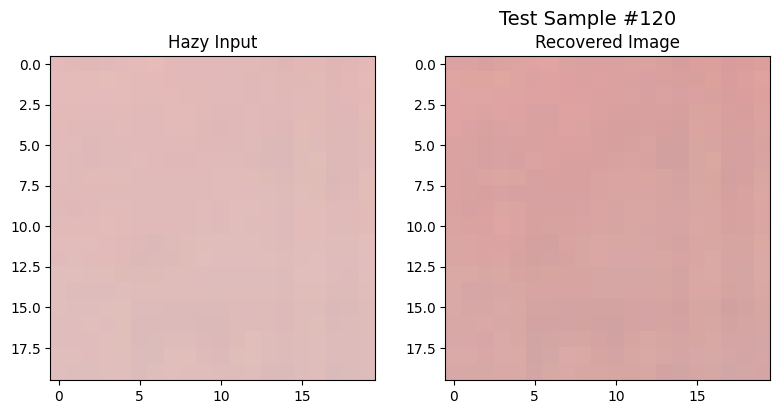

In [43]:
import matplotlib.pyplot as plt

for i in range(100,120):
    hazy_patch = X_test[i][:, :, :3]
    pred_t = y_pred_all[i]
    gt_t = y_test[i, :, :, 0]
    dehazed = image_recover(hazy_patch, pred_t)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(hazy_patch)
    plt.title("Hazy Input")

    plt.subplot(1, 3, 2)
    plt.imshow(dehazed)
    plt.title("Recovered Image")

    plt.suptitle(f"Test Sample #{i+1}", fontsize=14)
    plt.tight_layout()
    plt.show()


**FOR BIG IMAGE TESTING**


*   breaking into chunks and then individually dehazing and then combined





In [64]:
image_path = "/kaggle/input/outdoor-training-set-ots-reside/hazy/0138_0.9_0.1.jpg"


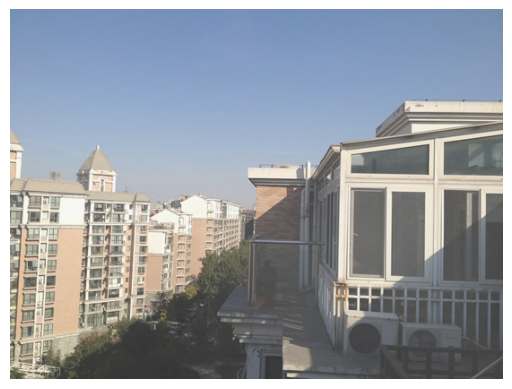

In [65]:
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis("off")
plt.show()


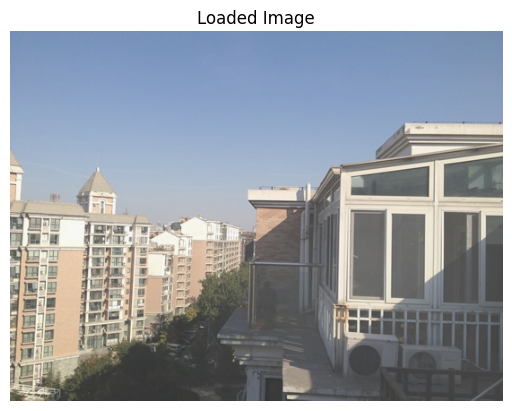

Image shape: (413, 550, 3)


In [63]:
import cv2
import matplotlib.pyplot as plt

# ---- Input image path ----
image_path = "/kaggle/input/outdoor-training-set-ots-reside/hazy/0138_0.9_0.1.jpg"   # change this to your image path

# Read the image (OpenCV loads in BGR)
img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)

if img_bgr is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Convert to RGB (for correct matplotlib display)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Loaded Image")
plt.show()

# Print numpy array shape
print("Image shape:", img_rgb.shape)


In [51]:
def image_breaker(img, patch_size = 20):
  patches =[]
  h,w,c = img.shape
  for i in range(0, h - patch_size + 1, patch_size):
    for j in range(0, w - patch_size + 1, patch_size):
      patch = img[i:i+patch_size, j:j+patch_size]
      patches.append((i,j,patch))
  return patches

In [52]:
dehazed_img_new = np.zeros_like(img_new)
A = (0.9, 0.9, 0.9)
for i, j, patch in image_breaker(img_new, 20):
    channels_total = extract_multiscale_dark_channels(patch)
    x_input_new = np.expand_dims(channels_total, axis=0)
    y_pred_new= model.predict(x_input_new)[0, :, :, 0]
    dehaze_img = image_recover(patch, y_pred_new,A)
    dehazed_img_new[i:i+20, j:j+20] = dehaze_img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

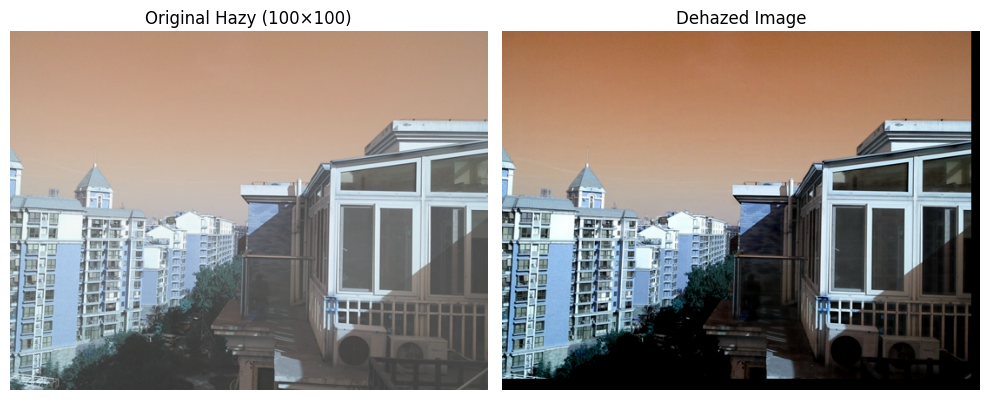

In [53]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_new)
plt.title("Original Hazy (100×100)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(dehazed_img_new)
plt.title("Dehazed Image")
plt.axis("off")

plt.tight_layout()
plt.show()


In [72]:
dehazed_img_new = cv2.cvtColor((dehazed_img_new * 255).astype('uint8'), cv2.COLOR_BGR2RGB)


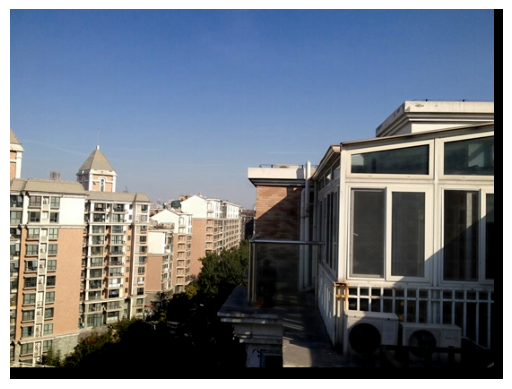

In [74]:

plt.imshow(dehazed_img_new)
plt.axis("off")
plt.show()


In [86]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_metrics(img1, img2):

    # Convert to float64 for precision
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    # Compute SSIM (for color images, compute over channels)
    if img1.ndim == 3 and img1.shape[2] == 3:
        ssim_val = ssim(img1, img2, channel_axis=-1, data_range=img1.max() - img1.min())
    else:
        ssim_val = ssim(img1, img2, data_range=img1.max() - img1.min())
    
    # Compute PSNR
    psnr_val = psnr(img1, img2, data_range=img1.max() - img1.min())

    # Compute MAE
    mae_val = np.mean(np.abs(img1 - img2))

    return {'SSIM': ssim_val, 'PSNR': psnr_val, 'MAE': mae_val}


In [80]:
img1 = cv2.imread("/kaggle/input/outdoor-training-set-ots-reside/hazy/0138_0.9_0.1.jpg")

In [81]:
img1

array([[[179, 142, 114],
        [182, 145, 117],
        [182, 145, 117],
        ...,
        [172, 141, 118],
        [171, 139, 116],
        [169, 138, 113]],

       [[179, 142, 114],
        [182, 145, 117],
        [181, 144, 116],
        ...,
        [172, 141, 120],
        [172, 140, 117],
        [171, 139, 116]],

       [[182, 143, 115],
        [184, 145, 117],
        [181, 144, 116],
        ...,
        [171, 139, 120],
        [171, 138, 119],
        [171, 138, 119]],

       ...,

       [[ 66,  91,  93],
        [ 71,  96,  98],
        [ 69,  93,  93],
        ...,
        [ 66,  66,  66],
        [ 68,  68,  68],
        [ 67,  67,  67]],

       [[ 76,  99, 101],
        [ 73,  96,  98],
        [ 73,  97,  97],
        ...,
        [ 67,  67,  67],
        [ 71,  71,  71],
        [ 70,  70,  70]],

       [[ 83, 103, 108],
        [ 78, 101, 103],
        [ 75,  99,  99],
        ...,
        [ 70,  70,  70],
        [ 78,  78,  78],
        [ 79,  79,  79]]

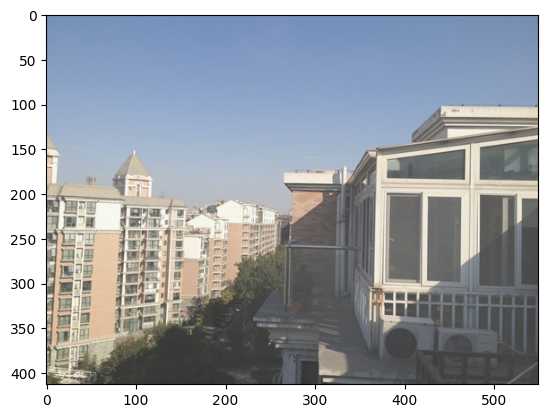

In [84]:
img1 = cv2.cvtColor(img1.astype('uint8'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)

In [87]:
from skimage import io
img1 = io.imread('/kaggle/input/clearots/clear/0138.jpg')

metrics = calculate_metrics(img1, dehazed_img_new)

print("SSIM:", metrics['SSIM'])
print("PSNR:", metrics['PSNR'])
print("MAE:", metrics['MAE'])

SSIM: 0.8583426810105689
PSNR: 22.041390033640567
MAE: 10.80597255851493


In [ ]:
img_path_new = "/content/test3.jpeg"
img_new_3 = cv2.imread(img_path_new)
img_new_3_orig = cv2.imread(img_path_new)
img_new_3 = img_new_3/255.0

In [ ]:
def shape_new(img, patch_size=20):
    h, w, c = img.shape
    new_h = h - (h % patch_size)
    new_w = w - (w % patch_size)
    return img[:new_h, :new_w, :]


In [ ]:
img_new_3 = shape_new(img_new_3)

In [ ]:
new_h , new_w, new_c = img_new_3.shape
print(new_h,new_w)

380 600


In [ ]:

dehazed_img_new_3 = np.zeros_like(img_new_3)

for i, j, patch in image_breaker(img_new_3, 20):
    channels_total_3 = extract_multiscale_dark_channels(patch)
    x_input_new_3 = np.expand_dims(channels_total_3, axis=0)
    y_pred_new_3= model.predict(x_input_new_3)[0, :, :, 0]
    dehaze_img_3 = image_recover(patch, y_pred_new_3)
    dehazed_img_new_3[i:i+20, j:j+20] = dehaze_img_3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

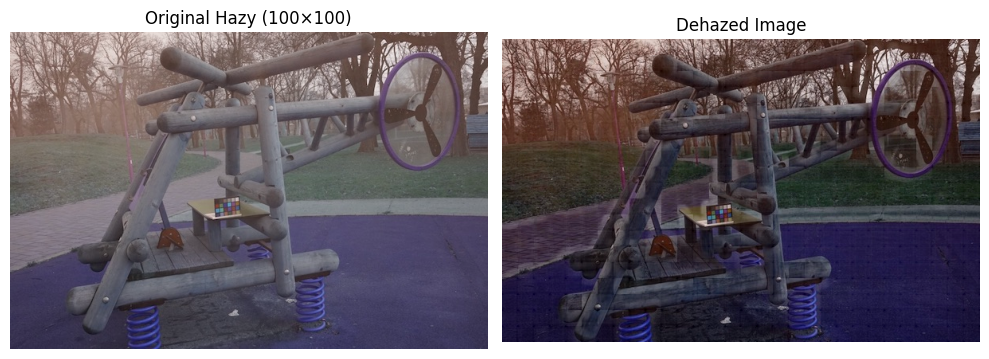

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_new_3_orig)
plt.title("Original Hazy (100×100)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(dehazed_img_new_3)
plt.title("Dehazed Image")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def dehaze_image_with_overlap(img, patch_size=20, stride=10):
    h, w, _ = img.shape
    sum_img = np.zeros_like(img, dtype=np.float32)
    weight_map = np.zeros((h, w), dtype=np.float32)

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape != (patch_size, patch_size, 3):
                continue  # skip edge cases

            features = extract_multiscale_dark_channels(patch)  # shape: (20, 20, 6)
            input_tensor = np.expand_dims(features, axis=0)     # (1, 20, 20, 6)
            pred_t = model.predict(input_tensor)[0, :, :, 0]    # shape: (20, 20)

            dehazed_patch = image_recover(patch, pred_t)        # shape: (20, 20, 3)

            # Accumulate outputs
            sum_img[i:i+patch_size, j:j+patch_size] += dehazed_patch
            weight_map[i:i+patch_size, j:j+patch_size] += 1.0

    # Avoid divide-by-zero
    weight_map = np.maximum(weight_map, 1e-8)
    weight_map = weight_map[..., np.newaxis]  # match (H, W, 1)

    final_img = sum_img / weight_map
    return np.clip(final_img, 0, 1)


In [ ]:
def dehaze_image_with_overlap(img, patch_size=20, stride=10):
    h, w, _ = img.shape
    sum_img = np.zeros_like(img, dtype=np.float32)
    weight_map = np.zeros((h, w), dtype=np.float32)

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape != (patch_size, patch_size, 3):
                continue  # skip edge cases

            features = extract_multiscale_dark_channels(patch)  # shape: (20, 20, 6)
            input_tensor = np.expand_dims(features, axis=0)     # (1, 20, 20, 6)
            pred_t = model.predict(input_tensor)[0, :, :, 0]    # shape: (20, 20)

            dehazed_patch = image_recover(patch, pred_t)        # shape: (20, 20, 3)

            # Accumulate outputs
            sum_img[i:i+patch_size, j:j+patch_size] += dehazed_patch
            weight_map[i:i+patch_size, j:j+patch_size] += 1.0

    # Avoid divide-by-zero
    weight_map = np.maximum(weight_map, 1e-8)
    weight_map = weight_map[..., np.newaxis]  # match (H, W, 1)

    final_img = sum_img / weight_map
    return np.clip(final_img, 0, 1)


In [ ]:
img_path_new = "/content/test3.jpeg"
img_new_4 = cv2.imread(img_path_new)
img_new_3_orig = cv2.imread(img_path_new)
img_new_4 = img_new_4/255.0

In [ ]:
img_new_4 = shape_new(img_new_4)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

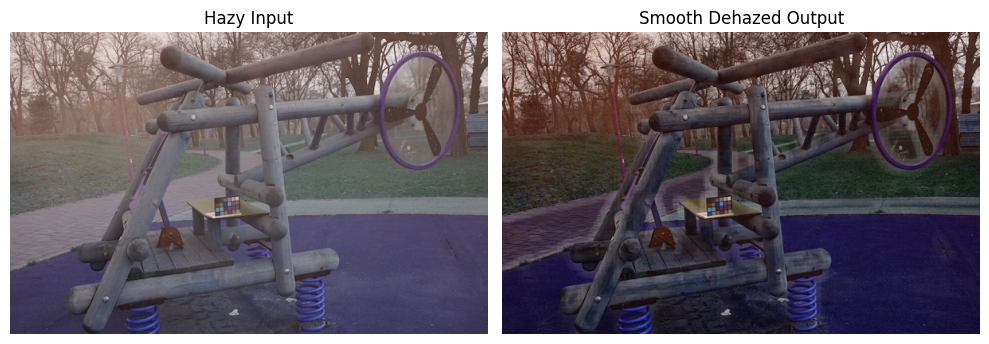

In [ ]:
# Crop to ensure size is divisible by stride if needed
img_fixed = shape_new(img_new_4, patch_size=20)

# Call the smooth dehazing function
dehazed_result = dehaze_image_with_overlap(img_fixed)

# Display
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_fixed)
plt.title("Hazy Input")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(dehazed_result)
plt.title("Smooth Dehazed Output")
plt.axis("off")
plt.tight_layout()
plt.show()
